In [34]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from sklearn import preprocessing
import os
import pathlib
import pandas as pd

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.image import resize

from tensorflow.keras import layers
from tqdm import tqdm

from skimage.color import rgb2gray

from tensorflow.keras.applications import Xception
from tensorflow.keras import Model

from tensorflow.data import Dataset
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

from dog_expert import utils

os.environ["CUDA_VISIBLE_DEVICES"]="1,2"

IMAGE_SIZE = (128, 128)

import importlib
importlib.reload(utils)

<module 'dog_expert.utils' from 'C:\\Users\\wprazuch\\Documents\\Projects\\dog-expert\\dog_expert\\utils.py'>

In [35]:
bing_path = pathlib.Path('datasets', 'bing')
data, labels = utils.load_by_classes(bing_path, no_images=300)



100%|██████████████████████████████████████████████████████████████████████████████| 124/124 [1:04:58<00:00, 31.44s/it]


In [37]:
stanford_path = pathlib.Path('datasets', 'stanford')
data_val, labels_val = utils.load_by_classes(stanford_path, no_images=300)

100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [13:44<00:00,  6.87s/it]


In [ ]:
def preprocess_input(data, labels):
    for i in tqdm(range(len(data))):
        try:
            data[i] = data[i].astype(np.float32)
            data[i] = resize(data[i], IMAGE_SIZE).numpy()
            #data[i] = rgb2gray(data[i])
            data[i] = 1./255. * data[i]
        except:
            del data[i]
            del labels[i]
    return data, labels

In [5]:
img = load_img(r'C:\Users\wprazuch\Pictures\Rozne\1.jpg')
img = np.array(img)
img = resize(img, IMAGE_SIZE).numpy()
#data[i] = rgb2gray(data[i])
img = 1./255. * img

In [6]:
cls = np.argmax(model.predict(np.expand_dims(img, axis=0)))

NameError: name 'model' is not defined

In [160]:
cls

85

In [161]:
cls = model.predict(np.expand_dims(img, axis=0))[0].argsort()

In [162]:
cls

array([120, 123, 121, 122,  47,  89,  75,   4,  64,  20,  96,  27,  41,
        62,  88, 102,  30, 106,  54, 104,  81,  87,   8,  26,  33, 103,
        51,  45,  76,  90,  50,   5,  72,  14,  91,   9,  43,  36,  63,
        46,  73,  79,  83,  24,  11,  69,  94,  66,   0,  98, 100,  23,
        59,  34,  17,  65,  68, 109,  39,  22,  28,  82,  29,  19,  18,
        92,  35,  38, 119,  78,  86, 101, 114,  55,  53, 107,  60,  25,
        56,  70,  57, 113,  84,  15,  49,  74,  21,   1,  97, 112,  42,
       116,  10,  58,  31,   2,  61,  12,  67,   7, 115,  32, 105,  80,
         3,  71,  95,  48,   6, 110, 108, 118,  77,  37,  16,  99,  44,
        13,  40, 117,  93,  52, 111,  85], dtype=int64)

In [163]:
cl = le.classes_[cls[:3]]

In [164]:
cl

array(['west_highland_white_terrier', 'yorkshire_terrier', 'whippet'],
      dtype='<U30')

In [7]:
data_raw = data.copy()

data, labels2 = preprocess_input(data_raw.copy(), labels.copy())



100%|████████████████████████████████████████████████████████████████████████████| 36003/36003 [13:10<00:00, 45.53it/s]


In [38]:
data_val2, labels_val2 = preprocess_input(data_val.copy(), labels_val.copy())

100%|███████████████████████████████████████████████████████████████████████████| 10222/10222 [01:10<00:00, 145.85it/s]


In [39]:
le = preprocessing.LabelEncoder()
labels_ord = le.fit_transform(labels)

labels_val_ord = le.fit_transform(labels_val2)

NUM_CLASSES = len(np.unique(labels_ord))
BATCH_SIZE=16

In [40]:
def to_tensor(data):
    data = np.array(data)
    data = tf.convert_to_tensor(data, dtype=tf.float32)
    return data

In [41]:
from tensorflow.keras.utils import to_categorical

In [42]:
labels_ord = to_categorical(labels_ord)
labels_val_ord = to_categorical(labels_val_ord)

In [47]:
data.shape

(36003,)

In [46]:
data = np.array(data)

ValueError: setting an array element with a sequence.

ValueError: setting an array element with a sequence.

In [13]:
def indices_to_one_hot(data, nb_classes):
    """Convert an iterable of indices to one-hot encoded labels."""
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets]

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [15]:
labels_one_hot = indices_to_one_hot(labels_ord, NUM_CLASSES)

In [16]:
data_ready, labels_one_hot = tf.cast(data_ready, tf.float32), tf.cast(labels_one_hot, tf.float32)

In [21]:
dataset = Dataset.from_tensor_slices((data_ready, labels_one_hot))
dataset = dataset.shuffle(30000)

In [22]:


DATASET_SIZE = len(dataset)

train_size = int(0.85 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)



train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [23]:
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(BATCH_SIZE)

In [24]:
base_model = Xception(weights= None, include_top=False, input_shape= (*IMAGE_SIZE,3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
# and a logistic layer -- let's say we have 200 classes
predictions = layers.Dense(NUM_CLASSES, activation='softmax')(x)

In [25]:
model = Model(inputs=base_model.input, outputs=predictions)

In [26]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00003), metrics=['accuracy'])

In [27]:
history = model.fit(train_dataset, validation_data=val_dataset,
                epochs=50)
                #callbacks=[checkpoint])

Epoch 1/50
1913/1913 [==============================] - 480s 251ms/step - loss: 4.5229 - accuracy: 0.0337 - val_loss: 4.0292 - val_accuracy: 0.0881
Epoch 2/50
1913/1913 [==============================] - 484s 253ms/step - loss: 4.0480 - accuracy: 0.0736 - val_loss: 3.6303 - val_accuracy: 0.1465
Epoch 3/50
1913/1913 [==============================] - 486s 254ms/step - loss: 3.6686 - accuracy: 0.1301 - val_loss: 2.9604 - val_accuracy: 0.2774
Epoch 4/50
1913/1913 [==============================] - 493s 258ms/step - loss: 3.1655 - accuracy: 0.2225 - val_loss: 2.2551 - val_accuracy: 0.4407
Epoch 5/50
1913/1913 [==============================] - 496s 259ms/step - loss: 2.5772 - accuracy: 0.3414 - val_loss: 1.6359 - val_accuracy: 0.5842
Epoch 6/50
1913/1913 [==============================] - 494s 258ms/step - loss: 1.9858 - accuracy: 0.4734 - val_loss: 1.0197 - val_accuracy: 0.7326
Epoch 7/50
1913/1913 [==============================] - 501s 262ms/step - loss: 1.4876 - accuracy: 0.5952 - val_

KeyboardInterrupt: 

In [68]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.000006), metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset,
                epochs=50)
                #callbacks=[checkpoint])

In [72]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.000003), metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset,
                epochs=50)
                #callbacks=[checkpoint])

In [95]:
a = train_dataset.unbatch()
a = list(dataset.as_numpy_iterator())

In [103]:
one = a[1000]

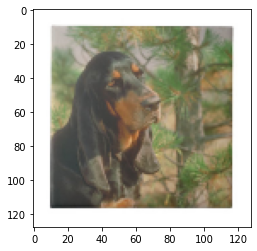

In [104]:
plt.imshow(one[0])

In [105]:
one[1]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

In [62]:
len(train_dataset)

855

In [63]:
len(val_dataset)

151

In [62]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.000006), metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset,
                epochs=50)
                #callbacks=[checkpoint])

In [158]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00003), metrics=['accuracy'])

In [159]:
history = model.fit(train_dataset, validation_data=val_dataset,
                epochs=50,
                shuffle=True)
                #callbacks=[checkpoint])

Epoch 1/50
543/543 [==============================] - 124s 228ms/step - loss: 4.7747 - accuracy: 0.0127 - val_loss: 4.7893 - val_accuracy: 0.0098
Epoch 2/50
543/543 [==============================] - 123s 226ms/step - loss: 4.7748 - accuracy: 0.0123 - val_loss: 4.7887 - val_accuracy: 0.0117
Epoch 3/50
543/543 [==============================] - 122s 226ms/step - loss: 4.7746 - accuracy: 0.0127 - val_loss: 4.7872 - val_accuracy: 0.0104
Epoch 4/50
543/543 [==============================] - 123s 226ms/step - loss: 4.7753 - accuracy: 0.0124 - val_loss: 4.7847 - val_accuracy: 0.0111
Epoch 5/50
543/543 [==============================] - 122s 225ms/step - loss: 4.7750 - accuracy: 0.0124 - val_loss: 4.7851 - val_accuracy: 0.0104
Epoch 6/50
543/543 [==============================] - 123s 227ms/step - loss: 4.7747 - accuracy: 0.0129 - val_loss: 4.7872 - val_accuracy: 0.0111
Epoch 7/50
543/543 [==============================] - 124s 227ms/step - loss: 4.7748 - accuracy: 0.0124 - val_loss: 4.7903 -